In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score, precision_score

### Task_1:

1.	взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)

In [2]:
# Чтоб 2 раза не вставать, буду предиктить на данных фондового рынка, так называемые данные OHLCV, где берется интервал,
# например, один торговый день, и все сделки за некоторый период, например, 3 года, семплируются по дням и вычисляются
# значения: цена начала периода (в данном случае дня), конца, минимальная за период, максимальная - Open, High, Low, Close
# ну и Volume - объем за период (кол-во проторгованных акций за период).

# Чтобы привести к бинарной классификации буду предиктить на n периодов вперед направлеине приращения цены.

In [3]:
files = [file for file in os.listdir() if 'csv' in file]
files

['AFLT.csv',
 'EURUSD15.csv',
 'EURUSD240.csv',
 'EURUSD30.csv',
 'EURUSD60.csv',
 'GAZP.csv',
 'LKOH.csv',
 'MGNT.csv',
 'micex_daily_artem.csv',
 'PLZL.csv',
 'ROSN.csv',
 'TATN.csv',
 'YNDX.csv']

In [4]:
df = pd.read_csv('AFLT.csv', sep=';')
df.head(5)

,<TIME>,<CLOSE>,<OPEN>,<HIGH>,<LOW>,<VOL>,<PER>,<TICKER>,<DATE>
0,180000,1.64,1.64,1.64,1.64,500,1,AFLT,19990322
1,180000,4.00,4.00,4.00,4.00,500,1,AFLT,19990811
2,180000,2.30,2.30,2.30,2.30,13250,1,AFLT,19990826
3,180000,0.01,2.50,2.50,0.01,2,1,AFLT,19990915
4,180000,1.30,1.30,1.30,1.30,1000,1,AFLT,19990922


### Task_2:

2.	сделать eda (как на занятии 6 с примером для оттока)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5055 entries, 0 to 5054
Data columns (total 9 columns):
<TIME>      5055 non-null int64
<CLOSE>     5055 non-null float64
<OPEN>      5055 non-null float64
<HIGH>      5055 non-null float64
<LOW>       5055 non-null float64
<VOL>       5055 non-null int64
<PER>       5055 non-null int64
<TICKER>    5055 non-null object
<DATE>      5055 non-null int64
dtypes: float64(4), int64(4), object(1)
memory usage: 355.5+ KB


In [6]:
df.columns = [column.lower()[1:-1] for column in df.columns]
df.columns

Index(['time', 'close', 'open', 'high', 'low', 'vol', 'per', 'ticker', 'date'], dtype='object')

In [7]:
df.index = df['date'].apply(lambda date_: datetime(year=int(str(date_)[:4]),
                                                  month=int(str(date_)[4:6]),
                                                  day=int(str(date_)[6:])))

In [8]:
df.head(1)

,time,close,open,high,low,vol,per,ticker,date
date,,,,,,,,,
1999-03-22,180000,1.64,1.64,1.64,1.64,500,1,AFLT,19990322


In [9]:
# Удаляю период, акцию - признак не информативен, одинаковые значения по всей выборке,
# дату, время удаляю, потому что собрал из них человеческую дату.
df.drop(columns=['time', 'date', 'ticker', 'per'], inplace=True)
df.rename(columns={'vol': 'volume'}, inplace=True)
df.head(3)

,close,open,high,low,volume
date,,,,,
1999-03-22,1.64,1.64,1.64,1.64,500
1999-08-11,4.00,4.00,4.00,4.00,500
1999-08-26,2.30,2.30,2.30,2.30,13250


C:\Users\Mihail\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


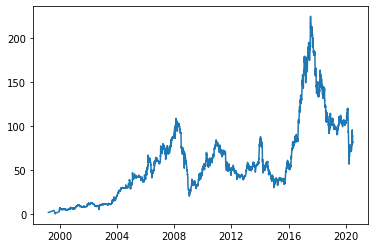

In [10]:
plt.plot(df['close'])

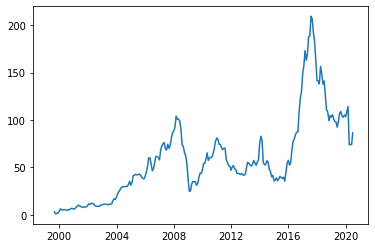

In [11]:
plt.plot(df.resample('M').mean()['close'])

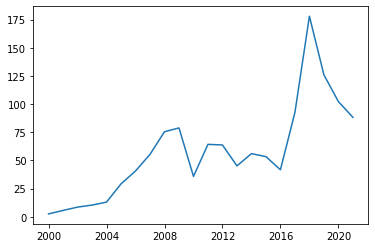

In [12]:
plt.plot(df.resample('Y').mean()['close'])

(array([1.553e+03, 9.760e+02, 3.940e+02, 2.650e+02, 1.810e+02, 1.540e+02,
        1.410e+02, 1.080e+02, 9.300e+01, 6.800e+01, 8.400e+01, 6.400e+01,
        7.500e+01, 6.800e+01, 5.600e+01, 6.100e+01, 4.900e+01, 6.200e+01,
        4.400e+01, 3.800e+01, 3.000e+01, 2.800e+01, 2.200e+01, 1.900e+01,
        2.400e+01, 2.000e+01, 2.500e+01, 1.400e+01, 1.000e+01, 1.700e+01,
        9.000e+00, 8.000e+00, 7.000e+00, 1.300e+01, 1.500e+01, 1.100e+01,
        9.000e+00, 7.000e+00, 1.200e+01, 1.300e+01, 9.000e+00, 1.100e+01,
        5.000e+00, 6.000e+00, 4.000e+00, 4.000e+00, 4.000e+00, 2.000e+00,
        4.000e+00, 5.000e+00, 5.000e+00, 3.000e+00, 3.000e+00, 4.000e+00,
        5.000e+00, 3.000e+00, 3.000e+00, 3.000e+00, 3.000e+00, 3.000e+00,
        2.000e+00, 1.000e+00, 4.000e+00, 6.000e+00, 1.000e+00, 3.000e+00,
        7.000e+00, 0.000e+00, 3.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        2.000e+00, 2.000e+00, 3.000e+00]),
 array([1.0000000e+00, 2.8337200e+04, 5.6673400e+04, 8.5009600e+04,
 

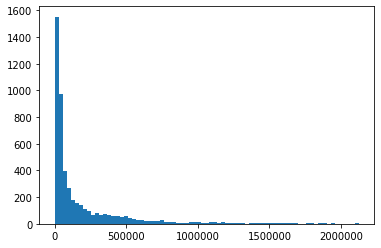

In [13]:
plt.hist(df.loc[df['volume'] < df['volume'].mean() + 3 * df['volume'].std(), 'volume'], bins=75)

Пропусков нет, данные такого типа мне знакомы, особо не смотрю что там, сосредоточюсь на feature engineering.

### Task_3:

3.	сделать feature engineering

##### TODO: нагенерить признаков из даты.

In [14]:
df.head(3)

,close,open,high,low,volume
date,,,,,
1999-03-22,1.64,1.64,1.64,1.64,500
1999-08-11,4.00,4.00,4.00,4.00,500
1999-08-26,2.30,2.30,2.30,2.30,13250


Нагенею некоторых признаков:

In [15]:
df['range'] = df['high'] - df['low']
df['movement'] = df['close'] - df['open']

df['MA_25'] = df['close'].rolling(25).mean()
df['MA_125'] = df['close'].rolling(125).mean()

df['close-MA_25'] = df['close'] - df['MA_25']
df['close-MA_125'] = df['close'] - df['MA_125']

df['MA25/MA125'] = (df['MA_25'] - df['MA_125']) / df['MA_125']

df['volume_MA_25'] = df['volume'].rolling(25).mean()
df['volume_MA_125'] = df['volume'].rolling(125).mean()

df['volume-MA_25'] = df['volume'] - df['volume_MA_25']
df['volume-MA_125'] = df['volume'] - df['volume_MA_125']

df['volume_MA25/volume_MA125'] = (df['volume_MA_25'] - df['volume_MA_125']) / df['volume_MA_125']

In [16]:
df = df[125:]
df.head(5)

,close,open,high,low,volume,range,movement,MA_25,MA_125,close-MA_25,close-MA_125,MA25/MA125,volume_MA_25,volume_MA_125,volume-MA_25,volume-MA_125,volume_MA25/volume_MA125
date,,,,,,,,,,,,,,,,,
2000-07-24,4.70,4.70,4.70,4.70,15800,0.00,0.00,4.7204,4.75424,-0.0204,-0.05424,-0.007118,14676.20,25773.776,1123.80,-9973.776,-0.430576
2000-07-27,4.66,4.65,4.67,4.65,1800,0.02,0.01,4.7068,4.75952,-0.0468,-0.09952,-0.011077,12588.20,25784.176,-10788.20,-23984.176,-0.511786
2000-07-31,4.70,4.70,4.70,4.70,28000,0.00,0.00,4.6820,4.77872,0.0180,-0.07872,-0.020240,13708.16,25902.176,14291.84,2097.824,-0.470772
2000-08-01,4.90,5.40,5.40,4.60,40300,0.80,-0.50,4.6640,4.81784,0.2360,0.08216,-0.031931,14277.60,26224.560,26022.40,14075.440,-0.455564
2000-08-02,5.00,4.90,5.00,4.90,386800,0.10,0.10,4.6656,4.84744,0.3344,0.15256,-0.037513,29742.36,29310.960,357057.64,357489.040,0.014718


Сделаем признаками приращения разной длины для всех признаков:

In [17]:
columns = df.columns
shifts_count = 3

for column in columns:
    for shift in range(1, shifts_count):
        df[f'{column}-{shift}'] = df[column].shift(shift) - df[column]

df = df[shifts_count:]

In [18]:
df.shape

(4927, 51)

In [19]:

df.head(5)

,close,open,high,low,volume,range,movement,MA_25,MA_125,close-MA_25,...,volume_MA_25-1,volume_MA_25-2,volume_MA_125-1,volume_MA_125-2,volume-MA_25-1,volume-MA_25-2,volume-MA_125-1,volume-MA_125-2,volume_MA25/volume_MA125-1,volume_MA25/volume_MA125-2
date,,,,,,,,,,,,,,,,,,,,,
2000-08-01,4.90,5.4,5.40,4.6,40300,0.80,-0.50,4.6640,4.81784,0.2360,...,-569.44,-1689.40,-322.384,-440.384,-11730.56,-36810.60,-11977.616,-38059.616,-0.015208,-0.056222
2000-08-02,5.00,4.9,5.00,4.9,386800,0.10,0.10,4.6656,4.84744,0.3344,...,-15464.76,-16034.20,-3086.400,-3408.784,-331035.24,-342765.80,-343413.600,-355391.216,-0.470282,-0.485490
2000-08-03,5.01,5.0,5.05,5.0,102902,0.05,0.01,4.6708,4.87632,0.3392,...,-3892.48,-19357.24,-817.216,-3903.616,287790.48,-43244.76,284715.216,-58698.384,-0.101673,-0.571955
2000-08-04,5.10,5.3,5.30,5.1,5311,0.20,-0.20,4.7008,4.90520,0.3992,...,753.56,-3138.92,53.512,-763.704,96837.44,384627.92,97537.488,382252.704,0.023070,-0.078604
2000-08-09,5.19,5.0,5.19,5.0,4699,0.19,0.19,4.7284,4.93456,0.4616,...,796.12,1549.68,-15.992,37.520,-184.12,96653.32,627.992,98165.480,0.027038,0.050108


In [20]:
columns_to_drop =\
[
    'open','high', 'low', 'volume',
    'MA_25', 'MA_125',
    'volume_MA_25', 'volume_MA_125'
]

df.drop(columns=columns_to_drop, inplace=True)

In [21]:
df.isna().sum().sum()

0

In [22]:
target_length = 10

df['target'] = df['close'].shift(-target_length) - df['close']

# Перед переводом таргета в бирарный формат направлений приращений запомню сами приращения.
movements = df['target']

df.loc[df['target'] < 0, 'target'] = 0
df.loc[df['target'] > 0, 'target'] = 1

df = df[:-target_length]
df.drop(columns=['close'], inplace=True)
df = df[1:]

movements = movements[:-target_length][1:]

df.head(1)

,range,movement,close-MA_25,close-MA_125,MA25/MA125,volume-MA_25,volume-MA_125,volume_MA25/volume_MA125,close-1,close-2,...,volume_MA_25-2,volume_MA_125-1,volume_MA_125-2,volume-MA_25-1,volume-MA_25-2,volume-MA_125-1,volume-MA_125-2,volume_MA25/volume_MA125-1,volume_MA25/volume_MA125-2,target
date,,,,,,,,,,,,,,,,,,,,,
2000-08-02,0.1,0.1,0.3344,0.15256,-0.037513,357057.64,357489.04,0.014718,-0.1,-0.3,...,-16034.2,-3086.4,-3408.784,-331035.24,-342765.8,-343413.6,-355391.216,-0.470282,-0.48549,1.0


### Task_4:

4.	обучить любой классификатор (какой вам нравится).

In [23]:
df.shape

(4916, 43)

Разделяю на train, test.

In [24]:
test_percent = 0.35

test_splitter = int(df.shape[0] * (1 - test_percent))

X_train = df[:test_splitter].copy()
y_train = df['target'][:test_splitter]

X_test = df[test_splitter:].copy()
y_test = df['target'][test_splitter:]

movements = movements[test_splitter:]

try:
    X_train.drop(columns='target', inplace=True)
    X_test.drop(columns='target', inplace=True)
except:
    pass

Обучение модели.

In [25]:
models = ['XGBoosting', 'forest']
model = models[0]

if model == 'XGBoosting':
    model = XGBClassifier(learning_rate=0.1,
                          max_depth=1,
                          n_estimators=250)
    model = model.fit(X_train, y_train)

elif model == 'forest':
    model = RandomForestClassifier(max_features=10, min_samples_leaf=125,
                          max_depth=10,
                          n_estimators=250)
    model.fit(X_train, y_train)

In [26]:
model.feature_importances_

array([0.07632137, 0.        , 0.03008287, 0.06487811, 0.06145738,
       0.03271784, 0.02891656, 0.0444884 , 0.04828013, 0.        ,
       0.02669152, 0.        , 0.02512218, 0.04638097, 0.02446019,
       0.        , 0.        , 0.        , 0.03703649, 0.02797762,
       0.        , 0.        , 0.03342849, 0.05847977, 0.0638532 ,
       0.03490969, 0.        , 0.03915522, 0.        , 0.        ,
       0.04226219, 0.05119237, 0.        , 0.04180674, 0.        ,
       0.03220234, 0.        , 0.        , 0.        , 0.        ,
       0.02789826, 0.        ], dtype=float32)

Важность признаков.

In [27]:
features = list(zip(X_test.columns, model.feature_importances_))

features.sort(key=lambda param: param[1], reverse=True)
features = [(feature[0], feature[1]) for feature in features][:25]
features[:10]

[('range', 0.07632137),
 ('close-MA_125', 0.064878106),
 ('MA_125-1', 0.063853204),
 ('MA25/MA125', 0.061457377),
 ('MA_25-2', 0.05847977),
 ('MA25/MA125-2', 0.051192373),
 ('close-1', 0.048280127),
 ('high-2', 0.04638097),
 ('volume_MA25/volume_MA125', 0.0444884),
 ('MA25/MA125-1', 0.04226219)]

Предикт и оценка результатов.

In [28]:
predict = model.predict(X_test)
predicted_proba = model.predict_proba(X_test)

print('порядок классов:', model.classes_)

roc_auc_score(y_test, predicted_proba[:,1]), roc_auc_score(y_test, predicted_proba[:,0]), precision_score(y_test, predict)

порядок классов: [0. 1.]


(0.5019533202391534, 0.4980466797608466, 0.5151515151515151)

In [29]:
models_results = pd.DataFrame({'description': ['labeled_learning'],
                              'roc_auc_negative_class': [roc_auc_score(y_test, predicted_proba[:,0])],
                              'roc_auc_positive_class': [roc_auc_score(y_test, predicted_proba[:,1])],
                              'precision_score': precision_score(y_test, predict)})

Доля успешных прогнозов: 0.509 
Количество предиктов: 974


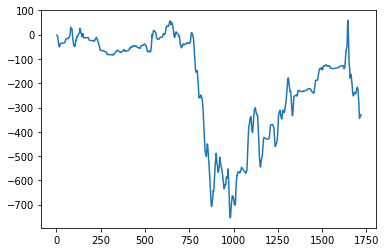

In [30]:
results = pd.DataFrame({'true': y_test, 'predict': predict, 'proba': predicted_proba[:, 0], 'movement': movements})
results['true_predict'] = 0

results.loc[results['true'] == results['predict'], 'true_predict'] = 1

results.reset_index(inplace=True)

# result - движение, которое получаем в сторону открытой позиции (в направлении предикта).
results.loc[results['true_predict'] == 1, 'result'] = np.abs(results['movement'])
results.loc[results['true_predict'] != 1, 'result'] = -np.abs(results['movement'])

# Лимит вероятности, при котором (по любому из классов) используем предикт. В данной предметной области главное получить
# высокую точность прогнозов, полнота не важна, получать предикт по каждому экземпляру тоже не обязательно.
proba_limit = 0.585

print('Доля успешных прогнозов:', round(results.loc[(results['proba'] > proba_limit) |\
                                             (results['proba'] < 1 - proba_limit)]['true_predict'].mean(), 3),
      '\nКоличество предиктов:', results.loc[(results['proba'] > proba_limit) |\
      (results['proba'] < 1 - proba_limit)]['true_predict'].count())

# Отрисуем накопленное движение в сторону предикта.
plt.plot(results.loc[(results['proba'] > proba_limit) | (results['proba'] < 1 - proba_limit), 'result'].expanding().sum())

Качество по направлениям предикта.

In [31]:
results.loc[(results['proba'] > proba_limit) | (results['proba'] < 1 - proba_limit)].groupby('predict')['true_predict'].mean()

predict
0.0    0.484627
1.0    0.567010
Name: true_predict, dtype: float64

Посмотрю как распределены величины вероятностей модели по объектам.

0.9490261673927307 5.603069172784058e-24 329.4784413289028 2.848823297976071e-72


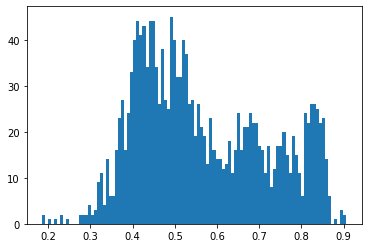

In [32]:
from scipy.stats import shapiro
from scipy import stats


data = results['proba'][:5000]
stat, p = shapiro(data)

stat2, p2 = stats.normaltest(data)

plt.hist(data, bins=100)

print(stat, p, stat2, p2)

In [33]:
results['proba'].mean(), results['proba'].median(), results['proba'].std()

(0.566299557685852, 0.52817302942276, 0.15404140949249268)

### Task_5:

5.	далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть

In [34]:
df.head(1)

,range,movement,close-MA_25,close-MA_125,MA25/MA125,volume-MA_25,volume-MA_125,volume_MA25/volume_MA125,close-1,close-2,...,volume_MA_25-2,volume_MA_125-1,volume_MA_125-2,volume-MA_25-1,volume-MA_25-2,volume-MA_125-1,volume-MA_125-2,volume_MA25/volume_MA125-1,volume_MA25/volume_MA125-2,target
date,,,,,,,,,,,,,,,,,,,,,
2000-08-02,0.1,0.1,0.3344,0.15256,-0.037513,357057.64,357489.04,0.014718,-0.1,-0.3,...,-16034.2,-3086.4,-3408.784,-331035.24,-342765.8,-343413.6,-355391.216,-0.470282,-0.48549,1.0


In [35]:
# Чекнул уникальность значений индекса на всякий (буду по индексу выборку делить).
len(set(df.index.unique())) == len(list(df.index))

True

Пусть positive класс - класс 1, т.е. приращение цены положительное.

In [36]:
df['target'].value_counts()

1.0    2548
0.0    2368
Name: target, dtype: int64

In [37]:
positive_index = df.loc[df['target'] == 1].sample(500).index
positive_index

DatetimeIndex(['2004-05-28', '2006-08-15', '2013-05-20', '2002-03-28',
               '2017-03-15', '2019-05-29', '2017-10-11', '2016-08-10',
               '2018-04-10', '2009-10-30',
               ...
               '2006-08-25', '2003-12-23', '2009-08-28', '2003-12-19',
               '2007-11-09', '2012-09-04', '2007-08-29', '2015-01-30',
               '2008-04-15', '2004-01-15'],
              dtype='datetime64[ns]', name='date', length=500, freq=None)

In [38]:
unlabeled_index = df.loc[~df.index.isin(positive_index)].index
len(unlabeled_index)

4416

In [39]:
unlabeled_index[:5]

DatetimeIndex(['2000-08-02', '2000-08-09', '2000-08-10', '2000-08-11',
               '2000-08-14'],
              dtype='datetime64[ns]', name='date', freq=None)

Полный список экземпляров позитивного и негативного класса.

In [40]:
positive_index_full = df.loc[df['target'] == 1].index
negative_index_full = df.loc[df['target'] == 0].index

### Task_6:

6.	применить random negative sampling для построения классификатора в новых условиях

In [41]:
# Берем 500 (чтобы классы были сбалансированынми) элементов из unlabeled и отобранные 500 позитивного класса
# для получения обучающей выборки.
negative_sampling_df = pd.concat([df.loc[df.index.isin(positive_index)],
                               df.loc[df.index.isin(unlabeled_index)].sample(500)])

negative_sampling_df.shape

(1000, 43)

Размечаем.

In [42]:
negative_sampling_df.loc[negative_sampling_df.index.isin(positive_index_full), 'target'] = 1
negative_sampling_df.loc[negative_sampling_df.index.isin(unlabeled_index), 'target'] = 0

Сплитим на обучающую и тестовую подвыборки.

In [43]:
features = list(df.columns)
features.remove('target')

# Перемешаем.
negative_sampling_df = negative_sampling_df.sample(negative_sampling_df.shape[0])

train_percent = 0.65
train_sep_index = int(negative_sampling_df.shape[0] * train_percent)

X_train = negative_sampling_df[:train_sep_index][features]
X_test = negative_sampling_df[train_sep_index:][features]

y_train = negative_sampling_df['target'][:train_sep_index]
y_test = negative_sampling_df['target'][train_sep_index:]

Обучаю модель.

In [44]:
models = ['XGBoosting', 'forest']
model = models[0]

if model == 'XGBoosting':
    model = XGBClassifier(learning_rate=0.1,
                          max_depth=1,
                          n_estimators=250)
    model = model.fit(X_train, y_train)

elif model == 'forest':
    model = RandomForestClassifier(max_features=10, min_samples_leaf=125,
                          max_depth=10,
                          n_estimators=250)
    model.fit(X_train, y_train)

Предикт и оценка результатов.

In [45]:
predict = model.predict(X_test)
predicted_proba = model.predict_proba(X_test)

print('порядок классов:', model.classes_)

roc_auc_score(y_test, predicted_proba[:,1]), roc_auc_score(y_test, predicted_proba[:,0]), precision_score(y_test, predict)

порядок классов: [0. 1.]


(0.5996408163265307, 0.40035918367346945, 0.554945054945055)

In [46]:
models_results = pd.concat([models_results,
                           pd.DataFrame({'description': ['pu_learning'],
                              'roc_auc_negative_class': [roc_auc_score(y_test, predicted_proba[:,0])],
                              'roc_auc_positive_class': [roc_auc_score(y_test, predicted_proba[:,1])],
                              'precision_score': precision_score(y_test, predict)})])

Качество прогноза для позитивного класса выросло. Что бы это значило... Негативный класс у нас "грязный", модели сложнее находить в нем закономерности (относительно варианта с истинным негативным классом), поэтому качество предикта по негативному классу ухудшилось. Но почему по позитивному классу качество предикта выросло, сдается мне, что работает только на выборках где негативный класс - это на самом деле unlabeled. Проверю гипотезу на выборке с истинно негативным классом. А, ну хотя если мы плохо предиктим один класс, то хорошо предиктим другой? - Тоже гипотеза.

In [47]:
models_results

,description,roc_auc_negative_class,roc_auc_positive_class,precision_score
0,labeled_learning,0.498047,0.501953,0.515152
0,pu_learning,0.400359,0.599641,0.554945


Проверка гипотезы про то, что хорошие результаты по одному классу, ведут к плохим по другому для бинарной классификации.

In [48]:
models_results.loc[models_results['description'] == 'labeled_learning', 'roc_auc_positive_class'] +\
models_results.loc[models_results['description'] == 'labeled_learning', 'roc_auc_negative_class']

0    1.0
dtype: float64

In [49]:
models_results.loc[models_results['description'] == 'pu_learning', 'roc_auc_positive_class'] +\
models_results.loc[models_results['description'] == 'pu_learning', 'roc_auc_negative_class']

0    1.0
dtype: float64

Подтверждается, данная метрика работает именно так, что сумма метрик для разных классов = 1.

Кстати, random_state не прописывал и, похоже, то что метрика для позитивного класса выросла как показывают доп. пара прогонов вполне может быть случайным вектором.

### Task_7:

7.	сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)

In [50]:
models_results

,description,roc_auc_negative_class,roc_auc_positive_class,precision_score
0,labeled_learning,0.498047,0.501953,0.515152
0,pu_learning,0.400359,0.599641,0.554945


Метрики, которые смотрят на качество предиктов по конкретному классу в целом для оценки качества предиктов на сбалансированной выборке, получается, нерелевантны. Одна растет -> другая падает и наоборот. Смотрим на precision_score - метрика закономерно упала. Зашумленные "грязной" разметкой данные дают ожидаемо худший результат при обучении с учителем, чем чистые данные, все четко. Можно было бы провести ещё несколько итерации уже с уверенно негативными метками, повышая качество модели и её предиктов.